# Attacks in Federated Learning (2)

Please complete the following tasks with the help of Claude and ChatGPT:

1. **Adapt the CNN code for MNIST** (from code **(3)**) to a federated learning framework.  
   - Integrate the CNN model into a setup where multiple clients train locally and send their parameters to a central server.

2. **Introduce attacks under i.i.d. data** across communication rounds, following these steps:
   - **Single communication round**:  
     When the server receives parameters from the clients (before averaging), apply the attack code from code **(3)** to recover each client’s data.
   - **Multiple communication rounds**:  
     Fix the attack to target only *client 1*. In each round, once the server receives parameters from client 1, execute the attack once. After \( T \) rounds, the server will have \( T \) separate attack results. **Compare** these results to evaluate how the attack evolves over multiple rounds.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.dropout2(x)
        x = self.fc2(x)

        x = F.softmax(x, dim=1)

        return x

In [ ]:
def load_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    return train_dataset, test_dataset

In [ ]:
def distribute_data(dataset, num_clients, iid=True):
    if iid:
        num_items_per_client = len(dataset) // num_clients
        client_datasets = []

        indices = torch.randperm(len(dataset))
        for i in range(num_clients):
            start_idx = i * num_items_per_client
            end_idx = (i + 1) * num_items_per_client if i < num_clients - 1 else len(dataset)
            client_indices = indices[start_idx:end_idx]
            client_datasets.append(Subset(dataset, client_indices))
    else:
        labels = dataset.targets.numpy()
        sorted_indices = np.argsort(labels)
        client_datasets = []
        shards_per_client = 2

        num_shards = num_clients * shards_per_client
        items_per_shard = len(dataset) // num_shards
        shard_indices = []

        for i in range(num_shards):
            start_idx = i * items_per_shard
            end_idx = (i + 1) * items_per_shard if i < num_shards - 1 else len(sorted_indices)
            shard_indices.append(sorted_indices[start_idx:end_idx])

        np.random.shuffle(shard_indices)

        for i in range(num_clients):
            client_idx = []
            for j in range(shards_per_client):
                client_idx.extend(shard_indices[i * shards_per_client + j])
            client_datasets.append(Subset(dataset, client_idx))

    return client_datasets

In [ ]:
class Client:
    def __init__(self, dataset, client_id, device):
        self.dataset = dataset
        self.client_id = client_id
        self.device = device
        self.model = CNN().to(device)
        self.dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    def train(self, epochs=1):
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        for epoch in range(epochs):
            total_loss = 0
            for batch_idx, (data, target) in enumerate(self.dataloader):
                data, target = data.to(self.device), target.to(self.device)

                optimizer.zero_grad()
                output = self.model(data)
                loss = F.cross_entropy(output, target)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        return total_loss / len(self.dataloader)

    def evaluate(self, test_loader):
        self.model.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)

        return test_loss, accuracy

    def get_parameters(self):
        return {k: v.cpu() for k, v in self.model.state_dict().items()}

    def set_parameters(self, parameters):
        params_on_device = {k: v.to(self.device) for k, v in parameters.items()}
        self.model.load_state_dict(params_on_device)

In [ ]:
class Server:
    def __init__(self, test_dataset, device):
        self.clients = []
        self.device = device
        self.global_model = CNN().to(device)
        self.test_loader = DataLoader(test_dataset, batch_size=128)

    def add_client(self, client):
        self.clients.append(client)

    def aggregate_parameters(self, client_parameters):
        global_dict = OrderedDict()

        for k in client_parameters[0].keys():
            global_dict[k] = torch.stack([client_parameters[i][k] for i in range(len(client_parameters))], 0).mean(0)

        return global_dict

    def update_global_model(self):
        client_parameters = [client.get_parameters() for client in self.clients]
        global_parameters = self.aggregate_parameters(client_parameters)

        self.global_model.load_state_dict({k: v.to(self.device) for k, v in global_parameters.items()})

        for client in self.clients:
            client.set_parameters(global_parameters)

        return client_parameters[0]  # Return client 1's parameters for potential attack

    def evaluate_global_model(self):
        self.global_model.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.global_model(data)
                test_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(self.test_loader.dataset)
        accuracy = 100. * correct / len(self.test_loader.dataset)

        return test_loss, accuracy

In [ ]:
class ModelInversionAttack:
    def __init__(self, model_params, target_class, device):
        self.model_params = model_params
        self.target_class = target_class
        self.device = device

    def perform_multimodel_attack(self, models_list, num_iterations=1000, learning_rate=0.01, reg_param=0.01):
        """
        Perform model inversion attack using multiple models with different parameters.

        Args:
            models_list: List of model parameters for different models
            num_iterations: Number of optimization iterations
            learning_rate: Learning rate for optimization
            reg_param: Regularization parameter for total variation loss

        Returns:
            Tuple of (recovered image, loss history)
        """
        loaded_models = []
        for model_params in models_list:
            model = CNN().to(self.device)
            model.load_state_dict({k: v.to(self.device) for k, v in model_params.items()})
            model.eval()
            loaded_models.append(model)

        # Initialize the recovered image
        recovered_image = torch.rand(1, 1, 28, 28, requires_grad=True, device=self.device)
        optimizer = optim.Adam([recovered_image], lr=learning_rate)

        # One-hot encode target class
        target = torch.zeros(1, 10, device=self.device)
        target[0, self.target_class] = 1

        losses = []

        for i in range(num_iterations):
            optimizer.zero_grad()

            # Calculate classification loss across all models
            classification_loss = 0
            for model in loaded_models:
                pred = model(recovered_image)
                classification_loss += -torch.sum(target * torch.log(pred + 1e-10))

            # Average the classification loss
            classification_loss /= len(loaded_models)

            # Total variation regularization
            tv_loss = torch.sum(torch.abs(recovered_image[:, :, :, :-1] - recovered_image[:, :, :, 1:])) + \
                      torch.sum(torch.abs(recovered_image[:, :, :-1, :] - recovered_image[:, :, 1:, :]))
            tv_loss = tv_loss * reg_param

            # L2 regularization
            l2_loss = torch.sum(recovered_image ** 2) * 0.001

            # Combine all losses
            total_loss = classification_loss + tv_loss + l2_loss

            # Backpropagate and update
            total_loss.backward()
            optimizer.step()

            # Clamp values to valid image range
            with torch.no_grad():
                recovered_image.clamp_(0, 1)

            # Log progress
            if i % 400 == 0:
                losses.append(classification_loss.item())
                print(f"[{i}, {classification_loss.item():.4f}]")

        # Convert final result to numpy array
        with torch.no_grad():
            recovered_image_np = recovered_image.cpu().numpy()

        return recovered_image_np, losses

    def perform_attack(self, num_iterations=1000, learning_rate=0.01, reg_param=0.01):
        model = CNN().to(self.device)
        model.load_state_dict({k: v.to(self.device) for k, v in self.model_params.items()})
        model.eval()

        recovered_image = torch.rand(1, 1, 28, 28, requires_grad=True, device=self.device)
        # recovered_image_2 = torch.rand(1, 1, 28, 28, requires_grad=True, device=self.device)

        # optimizer = optim.Adam([recovered_image, recovered_image_2], lr=learning_rate)
        optimizer = optim.Adam([recovered_image], lr=learning_rate)

        target = torch.zeros(1, 10, device=self.device)
        target[0, self.target_class] = 1

        losses = []

        for i in range(num_iterations):
            optimizer.zero_grad()

            pred = model(recovered_image)
            # pred_2 = model(recovered_image_2)

            classification_loss = -torch.sum(target * torch.log(pred + 1e-10)) #-torch.sum(target * torch.log(pred_2 + 1e-10))

            tv_loss = torch.sum(torch.abs(recovered_image[:, :, :, :-1] - recovered_image[:, :, :, 1:])) + \
                    torch.sum(torch.abs(recovered_image[:, :, :-1, :] - recovered_image[:, :, 1:, :]))
            tv_loss = tv_loss * reg_param

            # tv_loss_2 = torch.sum(torch.abs(recovered_image_2[:, :, :, :-1] - recovered_image_2[:, :, :, 1:])) + \
                    # torch.sum(torch.abs(recovered_image_2[:, :, :-1, :] - recovered_image_2[:, :, 1:, :]))
            # tv_loss_2 = tv_loss_2 * reg_param

            l2_loss = torch.sum(recovered_image ** 2) * 0.001
            # l2_loss_2 = torch.sum(recovered_image_2 ** 2) * 0.001

            total_loss = classification_loss + tv_loss + l2_loss #+ tv_loss_2 + l2_loss_2

            total_loss.backward()
            optimizer.step()

            with torch.no_grad():
                recovered_image.clamp_(0, 1)
                # recovered_image_2.clamp_(0, 1)

            if i % 800 == 0:
                losses.append(classification_loss.item())
                print(f"[{i}, {classification_loss.item():.4f}]")

        with torch.no_grad():
            recovered_image_np = recovered_image.cpu().numpy()
            # recovered_image_np = ((recovered_image + recovered_image_2) / 2).cpu().numpy()

        return recovered_image_np, losses

In [ ]:
def run_federated_learning(num_clients=3, num_rounds=3, local_epochs=1, iid=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    train_dataset, test_dataset = load_mnist()
    client_datasets = distribute_data(train_dataset, num_clients, iid=iid)

    server = Server(test_dataset, device)
    clients = []
    client_params_list = []

    for i in range(num_clients):
        client = Client(client_datasets[i], i, device)
        clients.append(client)
        server.add_client(client)

    global_accuracies = []
    client_losses = [[] for _ in range(num_clients)]

    # Federated learning loop
    for round_num in range(num_rounds):
        client_params_list.append([])

        print(f"\nRound {round_num+1}/{num_rounds}")

        for i, client in enumerate(clients):
            loss = client.train(epochs=local_epochs)
            client_losses[i].append(loss)
            print(f"Client {i+1} loss: {loss:.4f}")

            client_params_list[round_num].append(client.get_parameters())

        server.update_global_model()
        test_loss, accuracy = server.evaluate_global_model()
        global_accuracies.append(accuracy)
        print(f"Global model - Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return (global_accuracies, client_losses), (server, clients, client_params_list)

In [ ]:
num_clients = 10

(global_accuracies, client_losses), (server, clients, client_params_list) = run_federated_learning(
    num_clients=num_clients,
    num_rounds=10,
    local_epochs=1,
    iid=True
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_params = [clients[i].get_parameters() for i in range(num_clients)]

Using device: cuda

Round 1/10


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Client 1 loss: 1.7766
Client 2 loss: 1.8427
Client 3 loss: 1.8103
Client 4 loss: 1.8062
Client 5 loss: 1.7920
Client 6 loss: 1.7787
Client 7 loss: 1.8516
Client 8 loss: 1.7749
Client 9 loss: 1.8039
Client 10 loss: 1.8605
Global model - Test loss: 2.3020, Accuracy: 11.35%

Round 2/10
Client 1 loss: 1.8507
Client 2 loss: 1.8370
Client 3 loss: 1.8455
Client 4 loss: 1.8636
Client 5 loss: 1.8677
Client 6 loss: 1.8600
Client 7 loss: 1.8467
Client 8 loss: 1.8514
Client 9 loss: 1.8642
Client 10 loss: 1.8940
Global model - Test loss: 1.6395, Accuracy: 83.17%

Round 3/10
Client 1 loss: 1.7044
Client 2 loss: 1.6887
Client 3 loss: 1.6859
Client 4 loss: 1.6880
Client 5 loss: 1.6945
Client 6 loss: 1.6937
Client 7 loss: 1.6814
Client 8 loss: 1.6871
Client 9 loss: 1.6777
Client 10 loss: 1.6845
Global model - Test loss: 1.5671, Accuracy: 89.58%

Round 4/10
Client 1 loss: 1.6607
Client 2 loss: 1.6549
Client 3 loss: 1.6565
Client 4 loss: 1.6503
Client 5 loss: 1.6521
Client 6 loss: 1.6554
Client 7 loss: 1

In [ ]:
len(client_params_list[0])

3

In [ ]:
results = []
target_classes = range(0, 9 + 1)

for target_class in target_classes:
    print(f"Finished class: {target_class}")

    images = []

    attack = ModelInversionAttack(None, target_class, device)
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, transform=transforms.ToTensor()), batch_size=64)

    attacked_image, _ = attack.perform_multimodel_attack(
        # [
        #     client_params_list[0][0], # round 1, client 0
        #     client_params_list[1][0], # round 2, client 0
        #     client_params_list[2][0], # round 3, client 0
        #     client_params_list[3][0], # round 4, client 0
        #     client_params_list[4][0]  # round 5, client 0
        # ],
        model_params,
        num_iterations=400, # 1000
        learning_rate=0.1,  # 0.01
        reg_param=1e-4     # 1e-5
    )
    attacked_image = np.squeeze(attacked_image)

    images.append(attacked_image)
    results.append(images)

Finished class: 0
[0, 2.5600]


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Finished class: 1
[0, 2.5712]
Finished class: 2
[0, 2.2056]
Finished class: 3
[0, 1.1223]
Finished class: 4
[0, 2.7920]
Finished class: 5
[0, 2.2885]
Finished class: 6
[0, 3.7979]
Finished class: 7
[0, 3.0912]
Finished class: 8
[0, 2.4416]
Finished class: 9
[0, 3.4616]


In [ ]:
results = []
target_classes = range(10)

for i in range(num_clients):
    print(f"Attacking client: {i}")
    images = []

    for target_class in target_classes:
        attack = ModelInversionAttack(model_params[i], target_class, device)
        test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, transform=transforms.ToTensor()), batch_size=64)

        attacked_image, _ = attack.perform_multimodel_attack(model_params, num_iterations=1000, learning_rate=0.01, reg_param=1e-5)
        attacked_image = np.squeeze(attacked_image)
        images.append(attacked_image)

        print(f"Finished class: {target_class}")

    results.append(images)

In [ ]:
# fig, axes = plt.subplots(len(target_classes), num_clients, figsize=(10, 10))
fig, axes = plt.subplots(1, 2, figsize=(8, 8))

# for row in range(len(target_classes)):
for row in range(2):
    # for col in range(num_clients):
    for col in range(1):
        axes[row][col].imshow(results[col][row], cmap='gray')

        if row == 0:
            axes[row][col].set_title(f"Client: {col + 1}")

        axes[row][col].get_xaxis().set_visible(False)

        if col == 0:
            axes[row][col].set_ylabel(f"Class: {target_classes[row]}")
        else:
            axes[row][col].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
results[0]

1

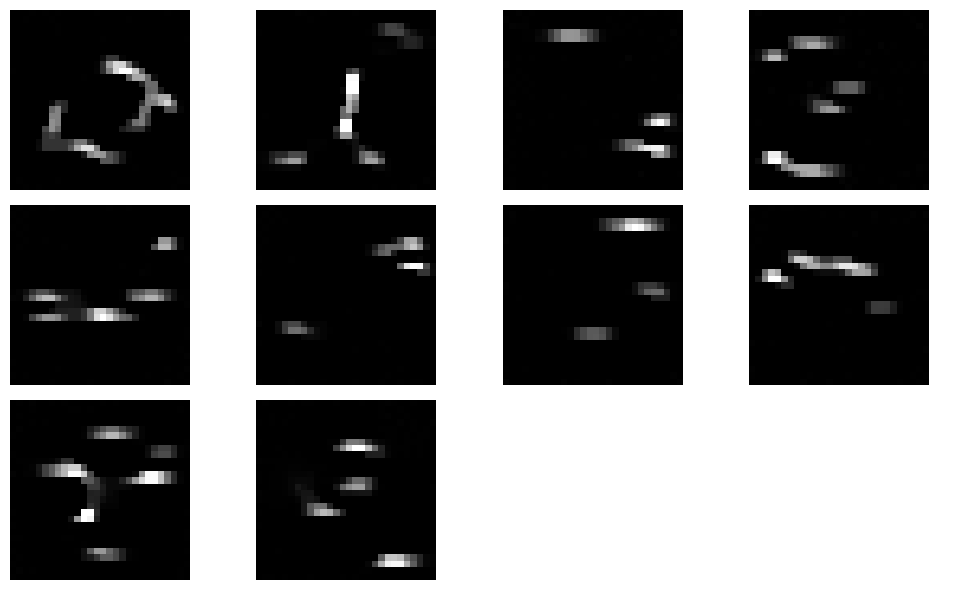

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(10, 6))

round = 0

for y in range(3):
    for x in range(4):
        if round <= 9:
            axes[y][x].imshow(results[round][0], cmap='gray')
        axes[y][x].axis("off")
        round += 1

plt.tight_layout()
plt.show()